
# Setting up the environment

First, we set up our environment. We use an already compiled and packaged installation of OpenMM and the DLExt plugin.
We copy it from Google Drive and install PySAGES for it.


In [1]:
%%bash

BASE_URL="https://drive.google.com/u/0/uc?id=1hsKkKtdxZTVfHKgqVF6qV2e-4SShmhr7&export=download"
wget -q --load-cookies /tmp/cookies.txt "$BASE_URL&confirm=$(wget -q --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate $BASE_URL -O- | sed -rn 's/.*confirm=(\w+).*/\1\n/p')" -O pysages-env.zip
rm -rf /tmp/cookies.txt

In [2]:
%env PYSAGES_ENV=/env/pysages

env: PYSAGES_ENV=/env/pysages


In [3]:
%%bash

mkdir -p $PYSAGES_ENV .
unzip -qquo pysages-env.zip -d $PYSAGES_ENV

In [5]:
import os
import sys

ver = sys.version_info
sys.path.append(os.environ["PYSAGES_ENV"] + "/lib/python" + str(ver.major) + "." + str(ver.minor) + "/site-packages/")

os.environ["XLA_FLAGS"] = "--xla_gpu_strict_conv_algorithm_picker=false"
os.environ["LD_LIBRARY_PATH"] = "/usr/lib/x86_64-linux-gnu:" + os.environ["LD_LIBRARY_PATH"]


## PySAGES

The next step is to install PySAGES.
First, we install the jaxlib version that matches the CUDA installation of this Colab setup. See the JAX documentation [here](https://github.com/google/jax) for more details.


In [6]:
%%bash

pip install -q --upgrade pip
# Installs the wheel compatible with CUDA 11 and cuDNN 8.0.5.
pip install -q --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html &> /dev/null


Now we can finally install PySAGES. We clone the newest version from [here](https://github.com/SSAGESLabs/PySAGES) and build the remaining pure python dependencies and PySAGES itself.


In [7]:
%%bash

rm -rf PySAGES
git clone https://github.com/SSAGESLabs/PySAGES.git &> /dev/null
cd PySAGES
pip install -q . &> /dev/null


# SpectralABF-biased simulations



SpectralABF gradually learns a better approximation to the coefficients of a basis functions expansion of the free energy of a system, from the generalized mean forces in a similar fashion to the ABF sampling method.

For this Colab, we are using alanine peptide in vacuum as example system.


In [8]:
%%bash

# Download pdb file with the initial configuration of our system
PDB_URL="https://raw.githubusercontent.com/SSAGESLabs/PySAGES/main/examples/inputs/alanine-dipeptide/adp-vacuum.pdb"
wget -q $PDB_URL

In [9]:
import numpy

from pysages.utils import try_import

openmm = try_import("openmm", "simtk.openmm")
unit = try_import("openmm.unit", "simtk.unit")
app = try_import("openmm.app", "simtk.openmm.app")


pi = numpy.pi

T = 298.15 * unit.kelvin
dt = 2.0 * unit.femtoseconds
adp_pdb = "adp-vacuum.pdb"


def generate_simulation(pdb_filename=adp_pdb, T=T, dt=dt):
    pdb = app.PDBFile(pdb_filename)

    ff = app.ForceField("amber99sb.xml")
    cutoff_distance = 1.0 * unit.nanometer
    topology = pdb.topology

    system = ff.createSystem(
        topology, constraints=app.HBonds, nonbondedMethod=app.PME, nonbondedCutoff=cutoff_distance
    )

    # Set dispersion correction use.
    forces = {}
    for i in range(system.getNumForces()):
        force = system.getForce(i)
        forces[force.__class__.__name__] = force

    forces["NonbondedForce"].setUseDispersionCorrection(True)
    forces["NonbondedForce"].setEwaldErrorTolerance(1.0e-5)

    positions = pdb.getPositions(asNumpy=True)

    integrator = openmm.LangevinIntegrator(T, 1 / unit.picosecond, dt)
    integrator.setRandomNumberSeed(42)

    simulation = app.Simulation(topology, system, integrator)
    simulation.context.setPositions(positions)
    simulation.minimizeEnergy()

    return simulation


Next, we load PySAGES and the relevant classes and methods for our problem


In [10]:
from pysages.grids import Grid
from pysages.colvars import DihedralAngle
from pysages.methods import SpectralABF

import pysages


The next step is to define the collective variable (CV). In this case, we choose the so called $\phi$ and $\psi$ dihedral angles of alanine dipeptide.

We define a grid, which will be used to indicate how we want to bin the forces that will be used to approximate the biasing potential and its gradient.


In [15]:
cvs = [DihedralAngle([4, 6, 8, 14]), DihedralAngle([6, 8, 14, 16])]
grid = pysages.Grid(lower=(-pi, -pi), upper=(pi, pi), shape=(64, 64), periodic=True)
timesteps = int(1e6)

method = SpectralABF(cvs, grid)


We now simulate the number of time steps set above.
Make sure to run with GPU support, otherwise, it can take a very long time.


In [16]:
run_result = pysages.run(method, generate_simulation, timesteps)


## Analysis

Let's plot the free energy!


In [18]:
import matplotlib.pyplot as plt
from pysages.approxfun import compute_mesh

In [20]:
result = pysages.analyze(run_result)
A = result["free_energy"]
# Aternatively to the line above:
# mesh = result["mesh"]
# fes_fn = result["fes_fn"]
# A = fes_fn(mesh)
A = A.max() - A
A = A.reshape(grid.shape)

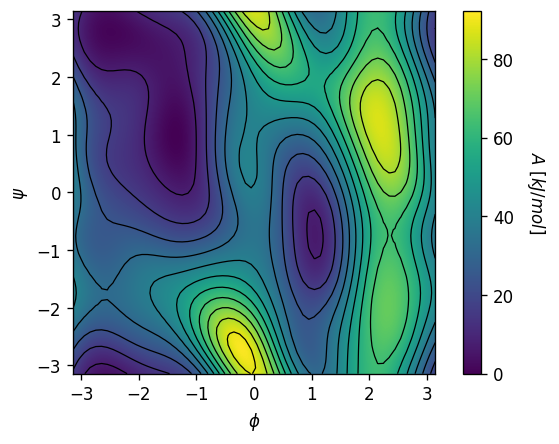

In [22]:
fig, ax = plt.subplots(dpi=120)

im = ax.imshow(
    A, interpolation="bicubic", origin="lower", extent=[-pi, pi, -pi, pi]
)
ax.contour(
    A, levels=12, linewidths=0.75, colors="k", extent=[-pi, pi, -pi, pi]
)
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\psi$")

cbar = plt.colorbar(im)
cbar.ax.set_ylabel(r"$A~[kJ/mol]$", rotation=270, labelpad=20)

plt.show()